In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets,models,transforms

import json
import os
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt


In [20]:
normalize = transforms.Normalize(
    mean =[0.485,0.456,0.406],
    std = [0.229,0.224,0.225])

preprocess = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
resize256 = transforms.Compose([
     transforms.CenterCrop(256)
])

In [21]:
def occluding(Img,i,j):
    oc_h,oc_w=64,64
    rImg=resize256(Img)
    img_np = np.asarray(rImg)
    img_np.flags.writeable = True
    h_top = i
    h_under = i+oc_h 
    w_left = j
    w_light = j+oc_w
    if(h_top < 0):
     h_top = 0 
    if(h_under > 256):
     h_under = 256
    if(w_left < 0):
     w_left = 0
    if(w_light > 256):
     w_light = 256
    #occluding
    img_np[h_top:h_under,w_left:w_light,:]=0
    return Image.fromarray(np.uint8(img_np))

In [22]:
def classid(Img,labels):
    img_tensor = preprocess(Img)
    img_tensor.unsqueeze_(0)
    out = vgg16(img_tensor)
    out = nn.functional.softmax(out,dim=1)
    out = out.data.numpy() 
    max_id = np.argmax(out)    
    label = labels[max_id][1]
    print(max_id,label)
    return max_id

In [23]:
def predict(Img,labels,id):
    img_tensor = preprocess(Img)
    img_tensor.unsqueeze_(0)
    out = vgg16(img_tensor)
    out = nn.functional.softmax(out,dim=1)
    out = out.data.numpy() 
    maxprob = out[:,id]
    label = labels[id] 
    return Img ,label, maxprob

In [34]:
def mheatmap(image,id):
    c = 0
    size = 39*39
    hm_w,hm_h = 256,256 #PIL.size > (width,height)
    class_index = json.load(open('imagenet_class_index.json', 'r'))
    labels = {int (key):value for (key,value) in class_index.items()}
    heatmap_li = []
    labelid = classid(image,labels)
    print(id,':gazo')
    for i in range(-56,hm_h,8):
     for j in range(-56,hm_w,8):
      c += 1
      oc_img=occluding(image,i,j)
      oc_img,oc_label,oc_prob = predict(oc_img,labels,labelid)
      heatmap_li.append(oc_prob)
     
    heatmap_np = np.array(heatmap_li)
    maps = np.reshape(heatmap_np,(39,39))
    mapsname = './'+'maps'+str(id)+'.npy'
    np.save(mapsname,maps)

In [35]:
def hm_img_show(image,maps):
     
     preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
        ])

     fig=plt.figure()
     ax1 = fig.add_subplot(1,2,1)
     #cm = plt.get_cmap('YlOrRd')
     ax1 = sns.heatmap(maps,cmap = 'YlOrRd')

     Img = occluding(image,64,64)
     Img = preprocess(Img)
     Img = np.array(Img)
     ax2 = fig.add_subplot(1,2,2)
     ax2.grid(color='none')
     ax2.imshow(Img)

     plt.show()

In [36]:
imagepass = '/export/space/okamoto-ka/imgdata2/'
imagename =[]
vgg16 = models.vgg16(pretrained = True)
vgg16.eval()   
for i in range(1,6):
    name = '%03d'%i +'.jpg'
    name = os.path.join(imagepass,name)
    imagename.append(name)

In [38]:
for i in range(5):
    image = Image.open(imagename[i])
    mheatmap(image,i+1)

146 albatross
1 :gazo
33 loggerhead
2 :gazo
146 albatross
3 :gazo
35 mud_turtle
4 :gazo
40 American_chameleon
5 :gazo


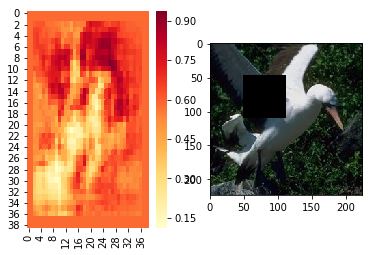

In [43]:
image = Image.open(imagename[0])
maps = np.load('maps1.npy')
hm_img_show(image,maps)

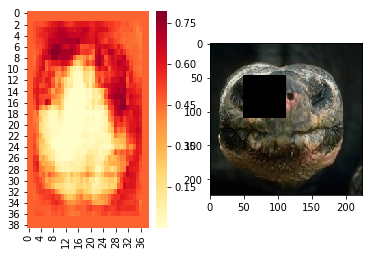

In [44]:
image = Image.open(imagename[1])
maps = np.load('maps2.npy')
hm_img_show(image,maps)

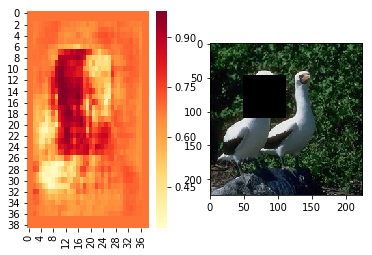

In [47]:
image = Image.open(imagename[2])
maps = np.load('maps3.npy')
hm_img_show(image,maps)

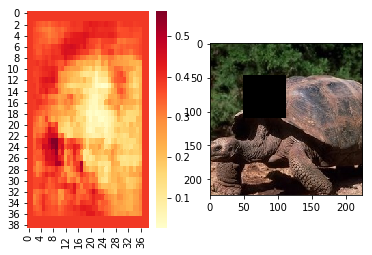

In [48]:
image = Image.open(imagename[3])
maps = np.load('maps4.npy')
hm_img_show(image,maps)

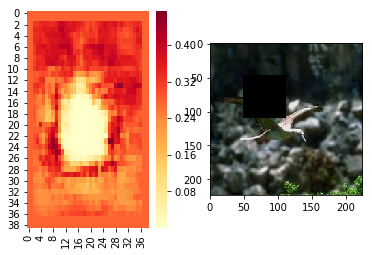

In [49]:
image = Image.open(imagename[4])
maps = np.load('maps5.npy')
hm_img_show(image,maps)